In [1]:
from pathlib import Path
import scanpy as sc

import torch
import torch.nn as nn

from torch.utils.data import DataLoader, Subset

from gettention.data import SCDataset
from gettention.model import PerformerClassifier, TransformerClassifier
import TOSICA

import numpy as np
import pandas as pd

from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (confusion_matrix,
ConfusionMatrixDisplay, classification_report)

import pickle

import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using: {device}")

Using: cuda


In [2]:
PROJ_ROOT = Path().resolve().parent
DATA_PATH = PROJ_ROOT / 'data' / 'pfalciparum'

FIG_PATH = PROJ_ROOT / 'report' / 'figures'

adata = sc.read_h5ad(filename= DATA_PATH / 'pf10xIDC.gz.h5ad')
sc_data = SCDataset(adata, 'bulk', 'log_trans', device)

In [3]:
sc_data.class_map

{(1, 0, 0, 0): 'early_troph',
 (0, 1, 0, 0): 'late_troph',
 (0, 0, 1, 0): 'ring',
 (0, 0, 0, 1): 'schizont'}

In [4]:
BATCH_SIZE = 8

test_idx_path = DATA_PATH / 'test_indices.pkl'
with test_idx_path.open('rb') as f:
    test_indices = pickle.load(f)

test_split = Subset(sc_data, test_indices)
test_loader = DataLoader(test_split, batch_size=BATCH_SIZE)


train_idx_path = DATA_PATH / 'train_indices.pkl'
with train_idx_path.open('rb') as f:
    train_indices = pickle.load(f)


In [5]:
PERFORMER_WEIGHTS_PATH = DATA_PATH / 'performer_model_weights.pth'
TRANSFORMER_WEIGHTS_PATH = DATA_PATH / 'transformer_model_weights.pth'

N_CELLS, M_GENES = sc_data.x.shape
K_CLASSES = sc_data.labels.shape[1]

performer = PerformerClassifier(
    N_CELLS,
    M_GENES,
    K_CLASSES
).to(device)

performer.load_state_dict(torch.load(PERFORMER_WEIGHTS_PATH))

<All keys matched successfully>

In [6]:
transformer = TransformerClassifier(
    ntoken=M_GENES,
    d_model=48,
    nhead=2,
    d_hid=200,
    nlayers=2,
    num_classes=K_CLASSES,
    learning_rate=1e-3,
).to(device)

transformer.load_state_dict(torch.load(TRANSFORMER_WEIGHTS_PATH))

/home/quercifolia/dev/gettention/.venv/lib/python3.11/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


<All keys matched successfully>

In [7]:
test_labs = adata[test_indices].obs.bulk.values

## Performer

In [8]:
test_preds = []
performer.eval()
with torch.no_grad():
    for vals, _ in iter(test_loader):
        test_pred = performer(vals)
        test = test_pred
        idx = torch.argmax(test_pred, dim=1, keepdims=True)
        test_pred = torch.zeros_like(test_pred).scatter_(1, idx, 1.).cpu().numpy()
        
        test_preds.append(test_pred)
test_preds = np.concatenate(test_preds)
pred_labs = [sc_data.class_map[tuple(pred.tolist())] for pred in test_preds]

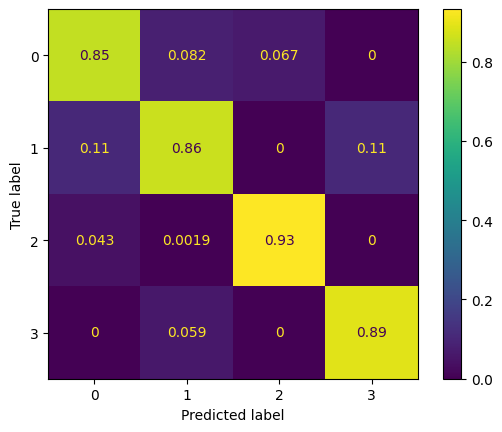

In [9]:
cf = confusion_matrix(test_labs, pred_labs, normalize="pred")
cf = ConfusionMatrixDisplay(cf).plot()
plt.savefig(FIG_PATH / 'performer_confusion.png', bbox_inches="tight", dpi = 300)

In [10]:
performer_report = classification_report(test_labs, pred_labs, output_dict=True, zero_division=0)

## Transformer

In [11]:
test_preds = []
transformer.eval()
with torch.no_grad():
    for vals, _ in iter(test_loader):
        test_pred = transformer(vals)
        idx = torch.argmax(test_pred, dim=1, keepdims=True)
        test_pred = torch.zeros_like(test_pred).scatter_(1, idx, 1.).cpu().numpy()
        
        test_preds.append(test_pred)
test_preds = np.concatenate(test_preds)
pred_labs = [sc_data.class_map[tuple(pred.tolist())] for pred in test_preds]

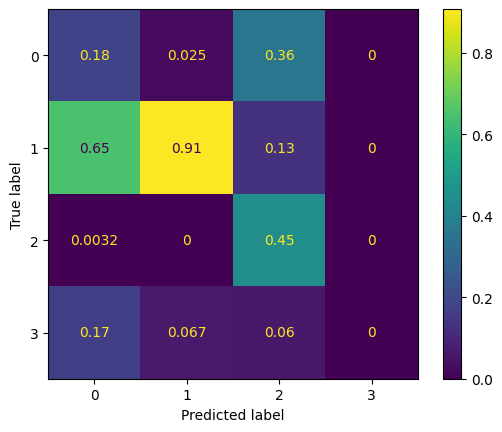

In [12]:
cf = confusion_matrix(test_labs, pred_labs, normalize="pred")
ConfusionMatrixDisplay(cf).plot()
plt.savefig(FIG_PATH / 'transformer_confusion.png', bbox_inches="tight", dpi = 300)

In [13]:
transformer_report = classification_report(test_labs, pred_labs, output_dict=True, zero_division=0)

## TOSICA

In [14]:
TOSICA_WEIGHTS_PATH = DATA_PATH / 'tosica' / 'model-4.pth'

In [15]:
test_adata = adata[test_indices].copy()

In [16]:
pred_adata = TOSICA.pre(test_adata, model_weight_path=TOSICA_WEIGHTS_PATH, project="tosica_pfalci")

cuda:0
0
2022


/home/quercifolia/dev/gettention/.venv/lib/python3.11/site-packages/anndata/_core/anndata.py:1897: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


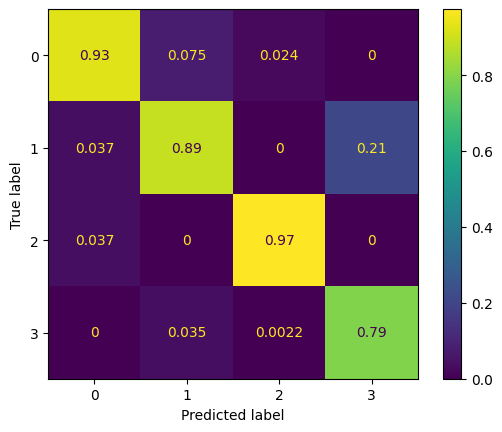

In [17]:
cf = confusion_matrix(pred_adata.obs.Prediction, pred_adata.obs.bulk, normalize="pred")
ConfusionMatrixDisplay(cf).plot()
plt.savefig(FIG_PATH / 'tosica_confusion.png', bbox_inches="tight", dpi = 300)

In [18]:
tosica_report = classification_report(pred_adata.obs.Prediction, pred_adata.obs.bulk, output_dict=True)

## SVM

In [19]:
X_train = adata.layers['log_trans'][train_indices]
X_test = adata.layers['log_trans'][test_indices]
y_train = adata[train_indices].obs.bulk.values

In [20]:
clf = svm.SVC(kernel='linear')
#Train the model using the training sets
clf.fit(X_train, y_train)

SVC(kernel='linear')

In [21]:
y_pred = clf.predict(X_test)

In [22]:
svm_report = classification_report(y_pred, test_labs, output_dict=True)

## Logistic Regression

In [23]:
logisticRegr = LogisticRegression(max_iter=1000)
logisticRegr.fit(X_train, y_train)
y_pred = logisticRegr.predict(X_test)

In [24]:
lr_report = classification_report(y_pred, test_labs, output_dict=True)

## GCN
Manual copy metrics....

In [25]:
# this is such a mess
pf_gcn = pd.read_csv(DATA_PATH / 'pf_gcn.csv').drop(['accuracy', 'macro avg', 'weighted avg'], axis = 1)

pf_gcn.rename(columns={pf_gcn.columns[0]: 'cell_type'}, inplace=True) 
pf_gcn.set_index('cell_type', inplace=True)

pf_gcn = pf_gcn.transpose()

pf_gcn['model'] = "gcn"
pf_gcn.reset_index(inplace=True)

pf_gcn.rename(columns={pf_gcn.columns[0]: 'cell_type'}, inplace=True) 

pf_gcn = pf_gcn.rename_axis(None, axis=1)

## Final Report

In [33]:
final_report = {"perf.": performer_report,
                "trans.": transformer_report,
                "tosica": tosica_report,
                "svm": svm_report,
                "lr": lr_report
               }

In [34]:
report_dfs = []

for report, metrics in final_report.items():
    df = (pd.DataFrame.from_dict(metrics)
 .drop(['accuracy', 'macro avg', 'weighted avg'], axis = 1)
 .transpose()
    )
    df['model'] = str(report)
    df.index.names = ['cell_type']
    df = df.reset_index()
    report_dfs.append(df)
    

In [35]:
report_df = pd.concat(report_dfs)

In [36]:
report_df = pd.concat([report_df, pf_gcn])

In [37]:
import seaborn as sns
sns.set_theme(style="whitegrid", palette='colorblind')

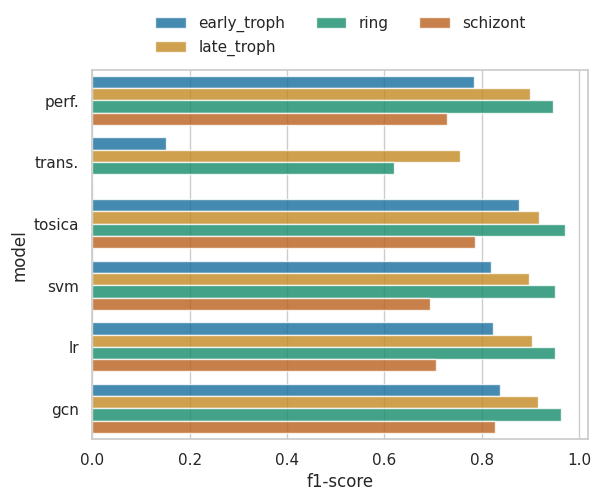

In [38]:
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)
g = sns.barplot(report_df, x = "f1-score", y = "model", hue = 'cell_type', alpha = 0.8)
sns.move_legend(
    g, "lower center",
    bbox_to_anchor=(.5, 1), ncol=3, title=None, frameon=False,
)

In [39]:
g.get_figure().savefig(FIG_PATH / 'f1_scores_bar.png', dpi = 300)

In [40]:
sc_data.class_map

{(1, 0, 0, 0): 'early_troph',
 (0, 1, 0, 0): 'late_troph',
 (0, 0, 1, 0): 'ring',
 (0, 0, 0, 1): 'schizont'}